# Code
## Import the desired libraries.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from pylab import rcParams
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

/Users/hoang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data preprocessing

In [5]:
df = pd.read_csv("../data/processminer-rare-event-mts.csv")

In [6]:
!pwd

/Users/hoang/Projects/2020-08-08-AbnormalDetection-Autoencoder/develop


The following UDF for the curve shifting

In [7]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

Before moving forward, we will drop the time, and also the categorical columns for simplicity.

In [8]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

## Splitting data

In [9]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]

df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]

df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]

df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

## Standardization

In [10]:
scaler = StandardScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)

df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

# Autoencoder Classifier

## Initialization

In [11]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
_________________________________________________________________


## Training 

In [12]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 11697 samples, validate on 2926 samples
Epoch 1/200
11697/11697 [==============================] - 0s 27us/step - loss: 2.0893 - acc: 0.0414 - val_loss: 1.5697 - val_acc: 0.0420
Epoch 2/200
11697/11697 [==============================] - 0s 11us/step - loss: 1.1753 - acc: 0.0449 - val_loss: 0.9747 - val_acc: 0.0420
Epoch 3/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.7964 - acc: 0.0604 - val_loss: 0.7724 - val_acc: 0.0776
Epoch 4/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.6700 - acc: 0.1030 - val_loss: 0.6879 - val_acc: 0.1159
Epoch 5/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.6034 - acc: 0.1181 - val_loss: 0.6240 - val_acc: 0.1326
Epoch 6/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.5527 - acc: 0.1412 - val_loss: 0.5741 - val_acc: 0.1524
Epoch 7/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.5134 - acc: 0.1595 - val_loss: 0.5379 - v

11697/11697 [==============================] - 0s 13us/step - loss: 0.2482 - acc: 0.4134 - val_loss: 0.2792 - val_acc: 0.4190
Epoch 60/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2484 - acc: 0.4206 - val_loss: 0.2731 - val_acc: 0.4299
Epoch 61/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2473 - acc: 0.4163 - val_loss: 0.2757 - val_acc: 0.4183
Epoch 62/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2466 - acc: 0.4149 - val_loss: 0.2687 - val_acc: 0.4354
Epoch 63/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2471 - acc: 0.4150 - val_loss: 0.2730 - val_acc: 0.4224
Epoch 64/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2510 - acc: 0.4162 - val_loss: 0.2721 - val_acc: 0.4368
Epoch 65/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2476 - acc: 0.4171 - val_loss: 0.2673 - val_acc: 0.4255
Epoch 66/200
11697/11697 [==============

Epoch 118/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2190 - acc: 0.4411 - val_loss: 0.2604 - val_acc: 0.4648
Epoch 119/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2207 - acc: 0.4401 - val_loss: 0.2360 - val_acc: 0.4576
Epoch 120/200
11697/11697 [==============================] - 0s 10us/step - loss: 0.2177 - acc: 0.4413 - val_loss: 0.2378 - val_acc: 0.4552
Epoch 121/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2194 - acc: 0.4441 - val_loss: 0.2403 - val_acc: 0.4586
Epoch 122/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2177 - acc: 0.4420 - val_loss: 0.2364 - val_acc: 0.4710
Epoch 123/200
11697/11697 [==============================] - 0s 13us/step - loss: 0.2158 - acc: 0.4416 - val_loss: 0.2372 - val_acc: 0.4590
Epoch 124/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2160 - acc: 0.4440 - val_loss: 0.2351 - val_acc: 0.4528
Epoch 125/200
11697/

11697/11697 [==============================] - 0s 17us/step - loss: 0.2061 - acc: 0.4523 - val_loss: 0.2334 - val_acc: 0.4788
Epoch 177/200
11697/11697 [==============================] - 0s 15us/step - loss: 0.2065 - acc: 0.4554 - val_loss: 0.2322 - val_acc: 0.4597
Epoch 178/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2084 - acc: 0.4570 - val_loss: 0.2285 - val_acc: 0.4662
Epoch 179/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2060 - acc: 0.4590 - val_loss: 0.2331 - val_acc: 0.4535
Epoch 180/200
11697/11697 [==============================] - 0s 11us/step - loss: 0.2065 - acc: 0.4553 - val_loss: 0.2311 - val_acc: 0.4474
Epoch 181/200
11697/11697 [==============================] - 0s 12us/step - loss: 0.2076 - acc: 0.4554 - val_loss: 0.2282 - val_acc: 0.4668
Epoch 182/200
11697/11697 [==============================] - 0s 14us/step - loss: 0.2084 - acc: 0.4550 - val_loss: 0.2349 - val_acc: 0.4655
Epoch 183/200
11697/11697 [=======

## Classification

If the reconstruction error is high, we will classify it as a sheet-break. We will need to determine the threshold for this. We will use the validation set to identify the threshold.

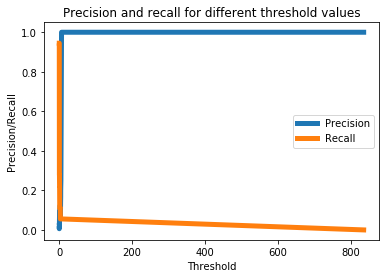

<Figure size 432x288 with 0 Axes>

In [17]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)

mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

plt.savefig('../figures/Precision_Recall.png')

we will perform classification on the test data.

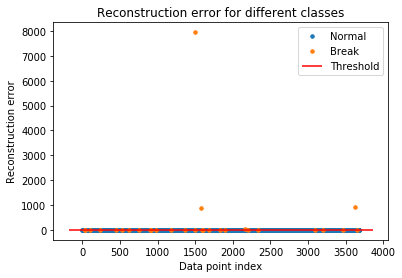

<Figure size 432x288 with 0 Axes>

In [18]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})

error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
plt.savefig("../figures/Fig2.Reconstruction_Error.png")

## Confusion matrix

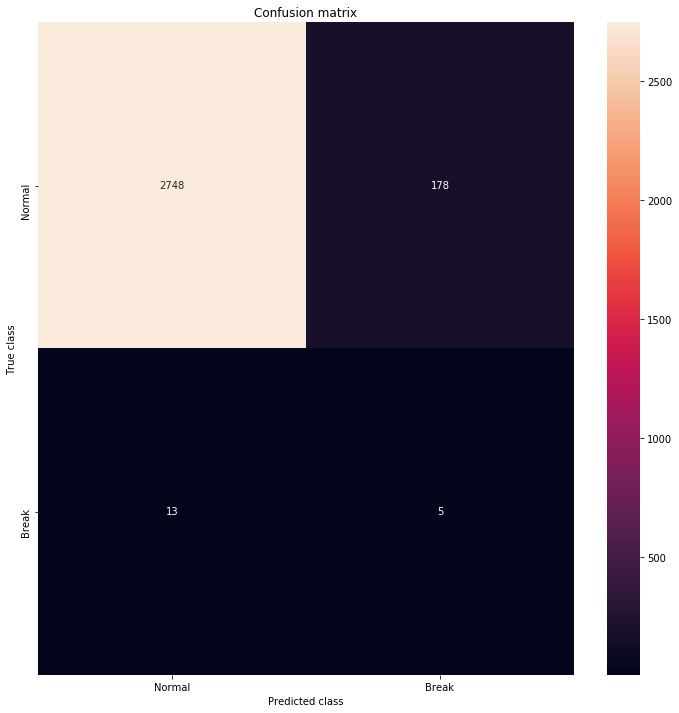

<Figure size 432x288 with 0 Axes>

In [19]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
plt.savefig("../figures/Confusion_Matrix")

## ROC curve and AUC

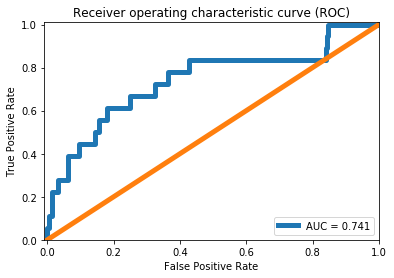

<Figure size 432x288 with 0 Axes>

In [20]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("../figures/AUC_ROC.png")